# Task optimisation using RL

This aims to design environments that produce maximally distinguishable behaviour between two learning models.

### Task

The task is a 2 armed bandit task, where the subject observes both outcomes on each trial. The "task" is to learn the value of each option ($A$ and $B$). Outcomes are binary (1 or 0), for example reward/no reward. No choices are made, the models just estimate the value of each option.

### Models

#### Model 1 = Basic Rescorla Wagner

For $A$ and $B$:
\begin{equation*}
V_{t+1}^A = V_t^A + \alpha\cdot(outcome^A - V_t^A)
\end{equation*}

#### Model 2 = Rescorla Wagner Pearce Hall hybrid

Alpha (learning rate) updated on every trial:

\begin{equation*}
\alpha_{t+1}^A = \alpha_t^A + k \cdot (\delta_t^2 - \alpha_t^A)
\end{equation*}


### Requirements:

* OpenAI gym
* Tensorflow <= 1.14
* Stable Baselines (https://stable-baselines.readthedocs.io)

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces
from stable_baselines.common.env_checker import check_env

C:\Users\tobyw\Miniconda3\envs\rl2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tobyw\Miniconda3\envs\rl2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tobyw\Miniconda3\envs\rl2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tobyw\Miniconda3\envs\rl2\lib\site-packages\tensorflow\python\frame

## Define learning model

In [2]:
def ph_learner(alpha, outcomes, k=0.3):
    v = np.ones(outcomes.shape + (len(alpha), )) * 0.5
    alpha_m = np.ones(outcomes.shape + (len(alpha), )) * alpha
    for n in range(outcomes.shape[1] - 1):
        pe = outcomes[:, n, None] - v[:, n, :]
        v[:, n+1, :] = v[:, n, :] + alpha_m[:, n, :] * pe
        alpha_m[:, n+1, :] = alpha_m[:, n, :] + k * (np.power(pe, 2) - alpha_m[:, n, :])
    return v

## Check that the models work

In [3]:
# One stimulus rewarded every other trial, other stimulus never rewarded
outcomes_test = np.zeros((2, 50))
outcomes_test[1, :] = 1
outcomes_test[1, ::2] = 0

rw_value = ph_learner(np.linspace(0.3, 0.7, 20), outcomes_test, k=0)  # RW is same as PH with K=0
ph_value = ph_learner(np.linspace(0.3, 0.7, 20), outcomes_test, k=0.3)

### Rescorla-Wagner value

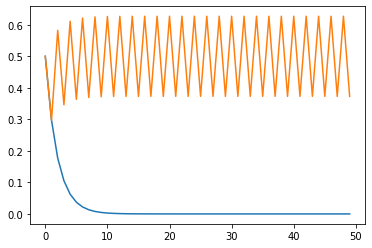

In [4]:
plt.plot(rw_value[..., 5].T)

### Pearce-Hall value

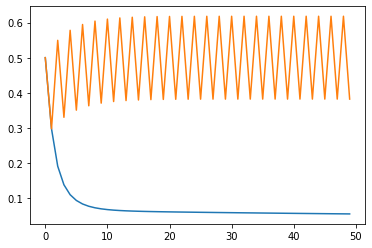

In [5]:
plt.plot(ph_value[..., 5].T)

## Create task environment

### Actions

Action space is discrete, with `n_trials * 2` actions. Each action places an outcome of 1 (e.g. reward). Actions < `n_trials` represent trials for stimulus 1, actions >= `n_trials` represent trials for stimulus 2. E.g. action 50 places a reward at trial 50, stimulus. Assuming 100 trials, action 101 places a reward at trial 2 for stimulus 2. If an action is taken twice (i.e. placing a reward at a trial that is already rewarded), this has no effect - this functions as a way to allow the agent to stop placing rewards by repeatedly choosing trials that have already been selected.

This repeats until there are as many rewards as trials (i.e. each stimulus has on average half the trials rewarded). 

### Reward

Each step provides 0 reward. Reward is given at the end of each episode and depends upon the difference between estimate value trajectories for the two learning models (specifically the sum of squared differences):

\begin{equation}
reward = \sum_{t=0}^{trials} (V_t^{PH} - V_t^{RW})^2
\end{equation}

This is done for a range of potential learning rates, the $k$ parameter in the Pearce-Hall model is set to 0.5


In [6]:
class BanditTaskEnv(gym.Env):

    def __init__(self, n_trials=80):
        super(BanditTaskEnv, self).__init__()
        self.n_trials = n_trials
        self.action_space = spaces.Discrete(n_trials * 2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(n_trials * 2, ), dtype=np.float32)

    def reset(self):
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """
        self.trial_outcomes = np.zeros((self.n_trials * 2, ))
        done = False
        return self.trial_outcomes

    def step(self, action):
        self.trial_outcomes[action] += 1

        done = bool(np.sum(self.trial_outcomes) >= self.n_trials)

        if done:
            outcomes_reshaped = self.trial_outcomes.reshape((2, self.n_trials))
            outcomes_reshaped[outcomes_reshaped > 1] = 1 # Any outcomes chosen more than once are set to 1
            
            # Alphas range from 0.2 to 0.8 (to cover a realistic range of possible alphas)
            vv1 = ph_learner(np.linspace(0.2, 0.8, 20), outcomes_reshaped, k=0)
            vv2 = ph_learner(np.linspace(0.2, 0.8, 20), outcomes_reshaped, k=0.5)
            
            ## REWARD - sum of squared differences between the two estimated values
            reward = (((vv1 - vv2) ** 2).sum()) 
        else:
            reward = 0

        info = {'action': action, 'done': done}

        return self.trial_outcomes, reward, done, info

    def close(self):
        pass
    

### Make sure the environment is valid

In [7]:
env = BanditTaskEnv()
check_env(env, warn=True)

### Step through the environment with random actions to make sure it works

In [8]:
env = BanditTaskEnv(n_trials=100)

obs = env.reset()

n_steps = 128
for step in range(n_steps):
    if step % 10 == 0:
        print("Step {}".format(step + 1))
    obs, reward, done, info = env.step(env.action_space.sample())
#     print('reward=', reward, 'done=', done, 'info=', info)
    if done:
        print("Done", "reward=", reward)
        print(obs)
        break

Step 1
Step 11
Step 21
Step 31
Step 41
Step 51
Step 61
Step 71
Step 81
Step 91
Done reward= 152.0132433136153
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 0.]


## Get some agents etc

This uses agents from Stable Baselines - https://stable-baselines.readthedocs.io/

In [9]:
from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.common.cmd_util import make_vec_env

# Instantiate the env
env = BanditTaskEnv(n_trials=100)
env = make_vec_env(lambda: env, n_envs=1)

## Train the agent

Using PPO - more iterations is better!

In [10]:
%time model = PPO2('MlpPolicy', env, verbose=0, tensorboard_log=".", cliprange_vf=-1).learn(500000)





Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Wall time: 7min 56s


### Check that action probabilities aren't all the same

Gives a rough idea of whether the agent has learnt anything

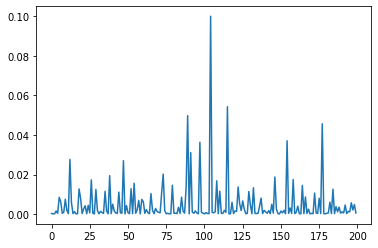

In [11]:
env = BanditTaskEnv(n_trials=100)
obs = env.reset()
plt.plot(model.action_probability(np.zeros_like(obs)).flatten())

## Create some environments

In [12]:
def get_pred_outcomes(env):
    
    obs = env.reset()
    for step in range(1000):
        action, _ = model.predict(obs, deterministic=False)
        new_obs, reward, done, info = env.step(action)
        if done:
            return (obs.reshape((2, 100)) > 0).astype(int)

In [13]:
env = BanditTaskEnv(n_trials=100)

rw_value_random = np.zeros((100, 2, 100, 20))
ph_value_random = np.zeros((100, 2, 100, 20))


for i in range(100):
    test_outcomes = np.zeros(200)
    test_outcomes[np.random.randint(0, 200, np.random.randint(0, 150))] = 1
    test_outcomes = test_outcomes.reshape((2, 100))
    rw_value_random[i, ...] = ph_learner(np.linspace(0.2, 0.8, 20), test_outcomes, k=0)
    ph_value_random[i, ...] = ph_learner(np.linspace(0.2, 0.8, 20), test_outcomes, k=0.5)
    
rw_value_rev = np.zeros((100, 2, 100, 20))
ph_value_rev = np.zeros((100, 2, 100, 20))

for i in range(100):
    test_outcomes = np.zeros((2, 100))
    test_outcomes[0, np.random.randint(0, 50, 35)] = 1
    test_outcomes[1, np.random.randint(0, 50, 15)] = 1
    test_outcomes[0, np.random.randint(50, 100, 15)] = 1
    test_outcomes[1, np.random.randint(50, 100, 35)] = 1
    rw_value_rev[i, ...] = ph_learner(np.linspace(0.2, 0.8, 20), test_outcomes, k=0)
    ph_value_rev[i, ...] = ph_learner(np.linspace(0.2, 0.8, 20), test_outcomes, k=0.5)
    
rw_value_pred = np.zeros((100, 2, 100, 20))
ph_value_pred = np.zeros((100, 2, 100, 20))

for i in range(100):
    test_outcomes = get_pred_outcomes(env)
    rw_value_pred[i, ...] = ph_learner(np.linspace(0.2, 0.8, 20), test_outcomes, k=0)
    ph_value_pred[i, ...] = ph_learner(np.linspace(0.2, 0.8, 20), test_outcomes, k=0.5)
    score = ((rw_value_pred[i, ...] - ph_value_pred[i, ...]) ** 2).sum()

optimised_score = ((rw_value_pred - ph_value_pred) ** 2).sum()
reversal_score = ((rw_value_rev - ph_value_rev) ** 2).sum()
random_score = ((rw_value_random - ph_value_random) ** 2).sum()
    
print('Optimised = ', optimised_score)
print('Reversal = ', reversal_score)
print('Random = ', random_score)

Optimised =  17759.63725645358
Reversal =  15248.455723415895
Random =  12914.598193050557


Text(0, 0.5, 'Score (higher = better)')

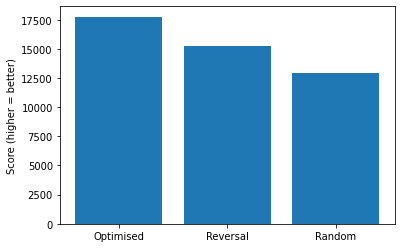

In [14]:
plt.bar(range(3), [optimised_score, reversal_score, random_score])
plt.xticks(range(3), ['Optimised', 'Reversal', 'Random'])
plt.ylabel('Score (higher = better)')

## Plot an example

In [15]:
test_outcomes = get_pred_outcomes(env)

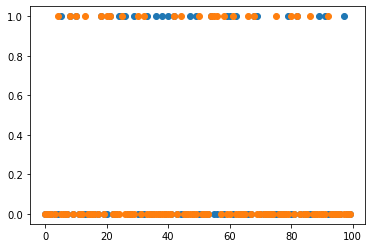

In [16]:
plt.scatter(range(100), test_outcomes[0, :])
plt.scatter(range(100), test_outcomes[1, :])

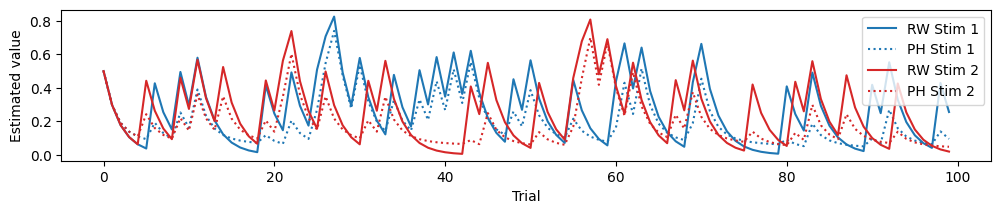

In [17]:
rw_value = ph_learner(np.linspace(0.3, 0.7, 20), test_outcomes, k=0)
ph_value = ph_learner(np.linspace(0.3, 0.7, 20), test_outcomes, k=0.3)

plt.figure(figsize=(12, 2), dpi=100)

plt.plot(rw_value[0, :, 5], color='tab:blue', label='RW Stim 1')
plt.plot(ph_value[0, :, 5], color='tab:blue', linestyle=':', label='PH Stim 1')

plt.plot(rw_value[1, :, 5], color='tab:red', label='RW Stim 2')
plt.plot(ph_value[1, :, 5], color='tab:red', linestyle=':', label='PH Stim 2')

plt.xlabel('Trial')
plt.ylabel('Estimated value')

plt.legend()